In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
J_KT = 0.3
H_KT = 0.1
chain_length = 60
ladder_length = 4

# Make Transfer Matrix

In [3]:
def Hamiltonian(config,J_KT,H_KT):
    H = J_KT * (config[0]*config[1]+config[2]*config[3]+config[4]*config[5]+config[6]*config[7])
    H += J_KT/2 * (config[6]*config[4]+config[4]*config[2]+config[2]*config[0]+config[7]*config[5]+
                   config[5]*config[3]+config[3]*config[1])
    H += H_KT/2 * (config[0]+config[1]+config[2]+config[3]+config[4]+config[5]+config[6]+config[7]) # or np.sum(config)
    return -H

In [4]:
T = np.empty((np.power(2,ladder_length), np.power(2,ladder_length)))
for i in range(0,np.power(2,2*ladder_length)):
    binary = np.base_repr(i, base=2)
    temp_str = '0' * (2*ladder_length - len(binary))
    temp_str = temp_str + binary
    config_array = np.empty(2*ladder_length)
    for ch_index in range(len(temp_str)) :
        if temp_str[ch_index] == '0' :
            config_array[ch_index] = 1
        else :
            config_array[ch_index] = -1
    hamiltonian = Hamiltonian(config_array,J_KT,H_KT)
    row = i // np.power(2,ladder_length)
    column = i % np.power(2,ladder_length)
    T[row][column] = np.exp(hamiltonian)

S_4 = np.diag([1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1])
S_3 = np.diag([1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1])
S_2 = np.diag([1,1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1])
S_1 = np.diag([1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1])
S = [S_1,S_2,S_3,S_4]

# Partition Function

In [5]:
partition_function = np.trace(np.linalg.matrix_power(T,chain_length))
partition_function

1.0098849862830412e+85

# Magnetization

In [6]:
index = 1
average_S_index = np.trace(np.linalg.matrix_power(T,index-1) @ S_1 @ np.linalg.matrix_power(T,chain_length-index+1))
magnetization = average_S_index / partition_function
magnetization

-0.034386694854785564

# Correlation Function

In [7]:
def correlation_function(i_1,j_1,i_2,j_2,T,partition_function):
    if (i_1>=i_2):
        i_1,i_2 = i_2,i_1

    correlation = np.trace(np.linalg.matrix_power(T,i_1-1) @ S[j_1] @ np.linalg.matrix_power(T,i_2-i_1) @ S[j_2] @ np.linalg.matrix_power(T,chain_length-i_2+1))
    correlation = correlation / partition_function
    return correlation

In [8]:
correlations = np.empty((ladder_length,chain_length))
middle_i_index = chain_length//2
middle_j_index = ladder_length//2
for i in range(0,chain_length*ladder_length):
    mi = i % chain_length
    mj = i // chain_length
    correlations[mj][mi] = correlation_function(mi+1,mj,middle_i_index+1,middle_j_index,T,partition_function)

Text(95.72222222222221, 0.5, 'Spin Index')

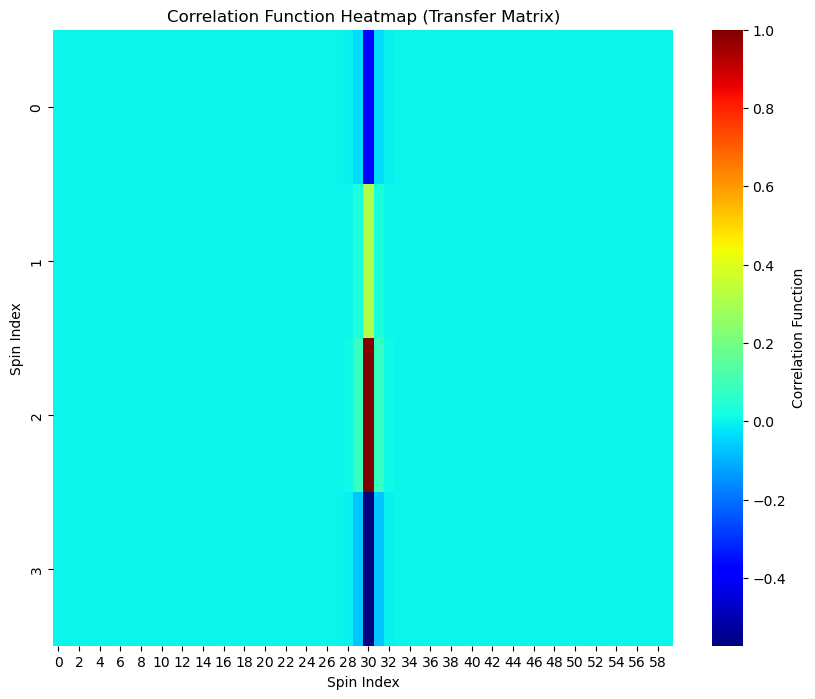

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, cmap='jet', annot=False, fmt=".2f", cbar_kws={'label': 'Correlation Function'})
plt.title('Correlation Function Heatmap (Transfer Matrix)')
plt.xlabel('Spin Index')
plt.ylabel('Spin Index')

# Monte Carlo Simulation

In [10]:
monte_carlo_magnetization = 0
monte_carlo_correlations = np.empty((ladder_length,chain_length))
random_init = np.random.randint(0, 2,(ladder_length, chain_length))
random_init = 2 * random_init - 1
step = 10000
ignore_step = 1000

for i_step in range(step):
    for j in range(ladder_length):
        for i in range(chain_length):
            S_UP = random_init[j-1][i]
            S_DOWN = random_init[(j+1)%ladder_length][i]
            S_RIGHT = random_init[j][(i+1)%chain_length]
            S_LEFT = random_init[j][i-1]
            S_I = random_init[j][i]
            delta_E = -2*(S_I*S_RIGHT+S_I*S_LEFT+S_I*S_DOWN+S_I*S_UP)*J_KT -2*S_I*H_KT
            if(delta_E <= 0 or np.exp(-delta_E) > np.random.random()):
                random_init[j][i] = -S_I
    if(i_step > ignore_step):
        monte_carlo_magnetization += np.mean(random_init)
        for k in range(ladder_length):
            for m in range(chain_length):
                monte_carlo_correlations[k][m] += random_init[k][m]*random_init[ladder_length//2][chain_length//2]


In [11]:
monte_carlo_magnetization = monte_carlo_magnetization / (step - ignore_step)
monte_carlo_magnetization

-0.0349000000000003

In [12]:
monte_carlo_correlations = monte_carlo_correlations / (step - ignore_step)

Text(95.72222222222221, 0.5, 'Spin Index')

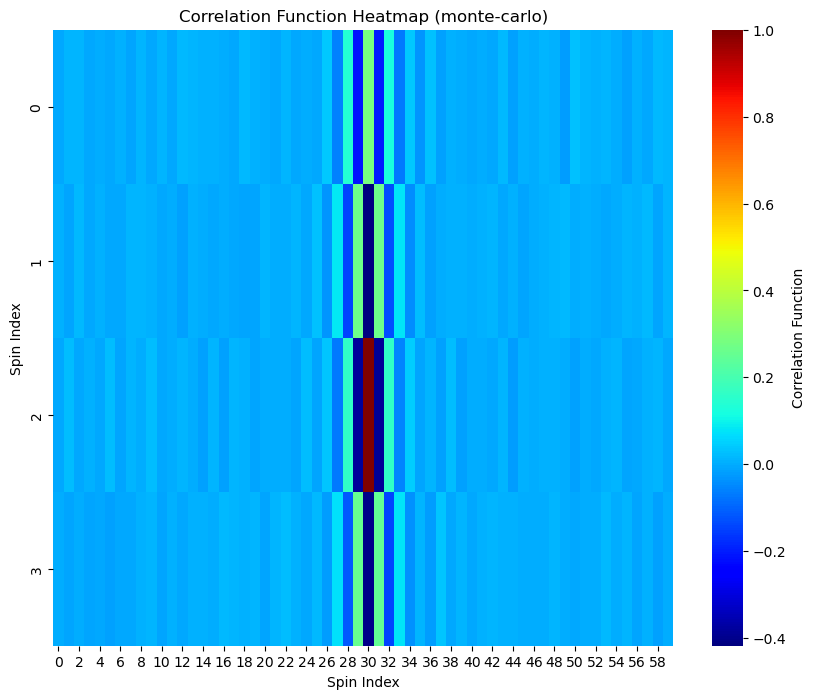

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(monte_carlo_correlations, cmap='jet', annot=False, fmt=".2f", cbar_kws={'label': 'Correlation Function'})
plt.title('Correlation Function Heatmap (monte-carlo)')
plt.xlabel('Spin Index')
plt.ylabel('Spin Index')